# Provided code

This code provides some examples of how to train a deep neural network for the Fashion-MNIST database.  You can use this as a training/test harness for developing your own ConvNet.

Note that you will probably want to change your runtime to use GPU rather than CPU for this task, if you are on Colab.

In [ ]:
%%time
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# import other utilities
import matplotlib.pyplot as plt

CPU times: user 429 ms, sys: 95.6 ms, total: 524 ms
Wall time: 3.55 s


## Data Loading

The following library call downloads the training set and puts it into data/FashionMNIST, and prepares the dataset to be passed into a pytorch as a tensor.

In [ ]:
%%time
# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

test_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = False,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!
CPU times: user 628 ms, sys: 301 ms, total: 929 ms
Wall time: 5.67 s


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Accuracy - Helper function

Auxiliary function that reports the accuracy on a dataset.

In [ ]:
def get_accuracy(model, dataloader):
    
    count=0
    correct=0

    model.eval()
    
    with torch.no_grad():
        for batch in dataloader:

            # Get inputs and labels
            images = batch[0]
            labels = batch[1]

            # Forward pass            
            preds = model(images)
            
            # Count correct and total samples
            batch_correct = preds.argmax(dim=1).eq(labels).sum().item()
            correct += batch_correct

            batch_count = len(batch[0])
            count += batch_count

    model.train()
    return correct / count

## MLP

Here I'm defining a network that is a 2-layer DNN.  You will want to replace this with the ConvNet definitions.

In [ ]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):

    def __init__(self):
        super().__init__()

        # Define layers
        self.fc1 = nn.Linear(in_features=28*28, out_features=200)
        self.fc2 = nn.Linear(in_features=200, out_features=10)


    # define forward function
    def forward(self, t):
        
        # fc 1
        t = t.reshape(-1, 28*28)
        t = self.fc1(t)
        t = F.relu(t)

        # fc 2
        t = self.fc2(t)
        # don't need softmax here since we'll use cross-entropy as activation.

        return t

Train the model for three epochs (by default); report the training set accuracy after each epoch.

In [ ]:
%%time
lr = 0.001
batch_size = 1000
shuffle = True
epochs = 10

network = Network()
loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
optimizer = optim.Adam(network.parameters(), lr=lr)

# Set the network to training mode
network.train()

for epoch in range(epochs):
    for batch in loader:
        
        # Get inputs and labels
        images = batch[0]
        labels = batch[1]

        # Forward pass
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        # Reset, Evaluate, then Update gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch {0}: train set accuracy {1}'.format(epoch, get_accuracy(network, loader)))

test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size)
print('Epoch {0}: test set accuracy {1}'.format(epoch, get_accuracy(network, test_loader)))

Epoch 0: train set accuracy 0.80425
Epoch 1: train set accuracy 0.83735
Epoch 2: train set accuracy 0.848
Epoch 3: train set accuracy 0.8507666666666667
Epoch 4: train set accuracy 0.8625
Epoch 5: train set accuracy 0.8673
Epoch 6: train set accuracy 0.8653
Epoch 7: train set accuracy 0.8772
Epoch 8: train set accuracy 0.8769833333333333
Epoch 9: train set accuracy 0.87875
Epoch 9: test set accuracy 0.8621
CPU times: user 1min 36s, sys: 144 ms, total: 1min 36s
Wall time: 1min 36s


# My implementation

## Baseline system

In [ ]:
# Extend nn.Module
class BaselineNet(nn.Module):

    def __init__(self):
        super(BaselineNet, self).__init__()

        # kernal
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=5, padding=2)

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(in_features=12*6*6, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)


    def forward(self, x):
        
        # Layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # Layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Layer 3
        x = torch.flatten(x, start_dim=1) # flatten all dimensions except the batch dimension
        x = self.fc1(x)
        x = F.relu(x)

        # Layer 4
        x = self.fc2(x)
        # Using F.cross_entropy as loss function later, 
        # which combines log_softmax and nll_loss in a single function
        # No need to explicitly use softmax activation
        # x = F.softmax(x, dim=1)

        return x
  
net = BaselineNet()
print(net)

BaselineNet(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=432, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
%%time
lr = 0.001
batch_size = 1000
shuffle = True
epochs = 10

network = BaselineNet()
loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
optimizer = optim.Adam(network.parameters(), lr=lr)

# Set the network to training mode
network.train()

for epoch in range(epochs):
    for batch in loader:
        
        # Get inputs and labels
        images = batch[0]
        labels = batch[1]

        # Forward pass
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        # Reset, Evaluate, then Update gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch {0}: train set accuracy {1}'.format(epoch, get_accuracy(network, loader)))

test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size)
print('Epoch {0}: test set accuracy {1}'.format(epoch, get_accuracy(network, test_loader)))

Epoch 0: train set accuracy 0.731
Epoch 1: train set accuracy 0.7638333333333334
Epoch 2: train set accuracy 0.7949833333333334
Epoch 3: train set accuracy 0.8229166666666666
Epoch 4: train set accuracy 0.8385666666666667
Epoch 5: train set accuracy 0.8430666666666666
Epoch 6: train set accuracy 0.8500833333333333
Epoch 7: train set accuracy 0.8555666666666667
Epoch 8: train set accuracy 0.8598
Epoch 9: train set accuracy 0.86435
Epoch 9: test set accuracy 0.853
CPU times: user 4min 17s, sys: 4.2 s, total: 4min 21s
Wall time: 4min 21s


## Comparison systems

### (1) Explore parameter tunning

In [ ]:
# Extend nn.Module
class CompareNet(nn.Module):

    def __init__(self, k):
        super(CompareNet, self).__init__()

        # kernal
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=k, padding=2)

        conv2_output_dim = 17 - k # 12 + 4 - k + 1
        maxpool_output_dim = torch.floor_divide(conv2_output_dim, 2)
        fc1_in_features = 12 * maxpool_output_dim * maxpool_output_dim

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(in_features=fc1_in_features, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)


    def forward(self, x):
        
        # Layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # Layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Layer 3
        x = torch.flatten(x, start_dim=1) # flatten all dimensions except the batch dimension
        x = self.fc1(x)
        x = F.relu(x)

        # Layer 4
        x = self.fc2(x)
        # Using F.cross_entropy as loss function later, 
        # which combines log_softmax and nll_loss in a single function
        # No need to explicitly use softmax activation
        # x = F.softmax(x, dim=1)

        return x
  
net = CompareNet(k=6)
print(net)

CompareNet(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 12, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=300, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
%%time
lr = 0.001
batch_size = 1000
shuffle = True
epochs = 10

k_seq = [3, 4, 5, 6, 7, 8]
accuracy_hist = []

for k in k_seq:
    print(f'For k = {k}:')

    network = CompareNet(k=k)
    loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
    optimizer = optim.Adam(network.parameters(), lr=lr)

    # Set the network to training mode
    network.train()

    for epoch in range(epochs):
        for batch in loader:
            
            # Get inputs and labels
            images = batch[0]
            labels = batch[1]

            # Forward pass
            preds = network(images)
            loss = F.cross_entropy(preds, labels)

            # Reset, Evaluate, then Update gradient
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('   Epoch {0}: train set accuracy {1}'.format(epoch, get_accuracy(network, loader)))

    test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size)
    test_accuracy = get_accuracy(network, test_loader)
    print('  Epoch {0}: test set accuracy {1}'.format(epoch, test_accuracy))
    accuracy_hist.append(test_accuracy)

For k = 3:
   Epoch 0: train set accuracy 0.7432666666666666
   Epoch 1: train set accuracy 0.79295
   Epoch 2: train set accuracy 0.8197833333333333
   Epoch 3: train set accuracy 0.8436333333333333
   Epoch 4: train set accuracy 0.8416666666666667
   Epoch 5: train set accuracy 0.8471333333333333
   Epoch 6: train set accuracy 0.8594
   Epoch 7: train set accuracy 0.8642833333333333
   Epoch 8: train set accuracy 0.8656333333333334
   Epoch 9: train set accuracy 0.8717166666666667
  Epoch 9: test set accuracy 0.8613
For k = 4:
   Epoch 0: train set accuracy 0.7423
   Epoch 1: train set accuracy 0.7847833333333334
   Epoch 2: train set accuracy 0.8079833333333334
   Epoch 3: train set accuracy 0.8216833333333333
   Epoch 4: train set accuracy 0.8394666666666667
   Epoch 5: train set accuracy 0.8460666666666666
   Epoch 6: train set accuracy 0.8530666666666666
   Epoch 7: train set accuracy 0.85595
   Epoch 8: train set accuracy 0.8650166666666667
   Epoch 9: train set accuracy 0.86465

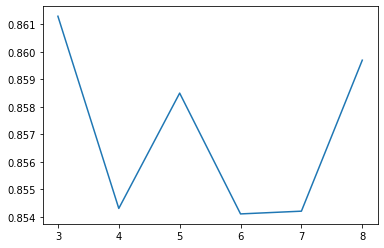

In [ ]:
plt.plot(k_seq, accuracy_hist)
plt.show()

The above graph shows the **test accuracies** under different k values. It seems the highest accuracy was achieved with a 3 by 3 convolution kernal, while other larger kernal sizes generally have a worse performance than the 3 by 3 kernal. I think the reason behind this is that **smaller** kernal can capture more regional features than larger kernals. Global features or larger features should be captured with more convolutional layers as a pooling result.

### (2) An improved architecture with higher accuracy

In [ ]:
# Extend nn.Module
class BetterNet(nn.Module):

    def __init__(self):
        super(BetterNet, self).__init__()
        
        # kernal
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=40, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=40, out_channels=80, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(in_features=6*6*80, out_features=800)
        self.fc2 = nn.Linear(in_features=800, out_features=10)


    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)
      
        # Layer 3
        x = torch.flatten(x, start_dim=1) # flatten all dimensions except the batch dimension
        x = self.fc1(x)
        x = F.relu(x)

        # Layer 4
        x = self.fc2(x)
        # Using F.cross_entropy as loss function later, 
        # which combines log_softmax and nll_loss in a single function
        # No need to explicitly use softmax activation
        # x = F.softmax(x, dim=1)

        return x
  
net = BetterNet()
print(net)

BetterNet(
  (layer1): Sequential(
    (0): Conv2d(1, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2880, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=10, bias=True)
)


In [ ]:
%%time
lr = 0.001
batch_size = 1000
shuffle = True
epochs = 10

network = BetterNet()
loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
optimizer = optim.Adam(network.parameters(), lr=lr)

# Set the network to training mode
network.train()

for epoch in range(epochs):
    for batch in loader:
        
        # Get inputs and labels
        images = batch[0]
        labels = batch[1]

        # Forward pass
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        # Reset, Evaluate, then Update gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch {0}: train set accuracy {1}'.format(epoch, get_accuracy(network, loader)))

test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size)
print('Epoch {0}: test set accuracy {1}'.format(epoch, get_accuracy(network, test_loader)))

Epoch 0: train set accuracy 0.8050166666666667
Epoch 1: train set accuracy 0.8600166666666667
Epoch 2: train set accuracy 0.8740833333333333
Epoch 3: train set accuracy 0.8878666666666667
Epoch 4: train set accuracy 0.8942666666666667
Epoch 5: train set accuracy 0.9023666666666667
Epoch 6: train set accuracy 0.9004833333333333
Epoch 7: train set accuracy 0.9144833333333333
Epoch 8: train set accuracy 0.9192833333333333
Epoch 9: train set accuracy 0.92505
Epoch 9: test set accuracy 0.9069
CPU times: user 19min 7s, sys: 11.6 s, total: 19min 18s
Wall time: 19min 19s


The final proposed model had a test accuracy around 90.5%.

I started with making the convolution kernals smaller (3 by 3) in both layers - this improved the model accuracy by quite a bit. With smaller convolution kernals (masks), the CNN can extract regional features.

Then I suplimented the model with more channels in each layer to improve the accuracy further. With 40 channels in the first convolutional layer and 80 in the second, the CNN is able to extract more features at each layers. This improves the predictive accuracy.

During the experiment, I also noticed that the improvement we could make becomes smaller as we keep increasing the number of channels in each layer. Adding more convolutional layers or fully connected layers did not help much with the accuracy. I also tried to make the subsampling (maxpooling) stride smaller, 1 instead of 2, but there is no meaningful improvement in accuracy. In addition, the training is suffering from significant slow-down due to high numbers of input / output channels.

I read some literatures online about training CNN - I found out it is also common to include regularizations in the network training, such as Dropout layers and BatchNorm layers, these can further improve the testing accuracy and speed up the training time. These architectures were not included in this project instructions, therefore were not implemented here.